# Vorticity-Streamfunction FD Python
## CH EN 6355 - Computational Fluid Dynamics
**Prof. Tony Saad (<a>www.tsaad.net</a>) <br/>Department of Chemical Engineering <br/>University of Utah**
<hr/>

## Synopsis
This notebook implements a finite difference solution of the 2D vorticity streamfunction approach for the constant density incompressible Navier-Stokes equations. These are given by
\begin{equation}
\frac{{\partial {\omega _z}}}{{\partial t}} =  - \frac{{\partial \psi }}{{\partial y}}\frac{{\partial {\omega _z}}}{{\partial x}} + \frac{{\partial \psi }}{{\partial x}}\frac{{\partial {\omega _z}}}{{\partial y}} + \nu {\nabla ^2}{\omega _z}
\end{equation}
\begin{equation}
\nabla ^2 \psi = -\omega_z
\end{equation}
along with $u =  \frac{\partial \psi}{\partial y}$ and $v =- \frac{\partial \psi}{\partial x}$. 

The solution procedure consists of the following steps:
1. Initialize $\omega$ in the domain and set $\omega$ and $\psi$ appropriately at the boundaries
2. Compute the streamfunction by solving the Poisson equation for the streamfunction-vorticity relation
3. Solve the vorticity transport equation using an appropriate discretization scheme in time and space

For this notebook, we will use an FTCS scheme (Forward in Time, Central in Space). We have
\begin{equation}
\frac{{\partial {\omega _z}}}{{\partial t}} \approx \frac{{\omega _{i,j}^{n + 1} - \omega _{i,j}^n}}{{\Delta t}}
\end{equation}
\begin{equation}
- \frac{{\partial \psi }}{{\partial y}}\frac{{\partial {\omega _z}}}{{\partial x}} =  - \left( {\frac{{\psi _{i,j + 1}^n - \psi _{i,j - 1}^n}}{{2\Delta y}}} \right)\left( {\frac{{\omega _{i + 1,j}^n - \omega _{i - 1,j}^n}}{{2\Delta x}}} \right)
\end{equation}
\begin{equation}
\frac{{\partial \psi }}{{\partial x}}\frac{{\partial {\omega _z}}}{{\partial y}} = \left( {\frac{{\psi _{i + 1,j}^n - \psi _{i - 1,j}^n}}{{2\Delta x}}} \right)\left( {\frac{{\omega _{i,j + 1}^n - \omega _{i,j - 1}^n}}{{2\Delta y}}} \right)
\end{equation}
and
\begin{equation}
{\nabla ^2}{\omega _z} = \frac{{\omega _{i + 1,j}^n - 2\omega _{i,j}^n + \omega _{i - 1,j}^n}}{{\Delta {x^2}}} + \frac{{\omega _{i,j + 1}^n - 2\omega _{i,j}^n + \omega _{i,j - 1}^n}}{{\Delta {y^2}}}
\end{equation}

In [6]:
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import cm
plt.rcParams['animation.html'] = 'html5'

In [7]:
nx = 21
ny = 21
lx = 1.0
ly = 1.0
dx = lx/(nx-1)
dy = ly/(ny-1)

In [8]:
Ut = 5.0 # u top wall
Ub = 0.0 # u bottom wall
Vl = 0.0 # V left wall
Vr = 0.0 # V right wall

In [9]:
ψ0 = np.zeros([ny,nx])
ω0 = np.zeros([ny,nx])

# apply boundary conditions
ω0[0,1:-1]  = -2.0*ψ0[1, 1:-1]/dy/dy + 2.0*Ub/dy     # vorticity on bottom wall (stationary)
ω0[-1,1:-1] = -2.0*ψ0[-2, 1:-1]/dy/dy - 2.0*Ut/dy # vorticity on top wall (moving at Uwall)
ω0[1:-1,-1] = -2.0*ψ0[1:-1,-2]/dx/dx # right wall
ω0[1:-1,0]  = -2.0*ψ0[1:-1,1]/dx/dx # left wall

# ω0[ny//2,:nx//2] = 1.0/dy
# ω0[ny//2-1,nx//2:] = 1/dy

t = 0.0
dt = 0.001

tol = 1e-3
maxIt = 30
β = 1.5
ν = 0.05
psi = []
psi.append(ψ0)
omega = []
omega.append(ω0)
# plt.contour(omega[0])
dt = min(0.25*dx*dx/ν, 4.0*ν/Ut/Ut)
tend = 4*dt
# print(ν*dt/dx/dx <= 0.25)
# print(Ut**2*dt/ν <= 4.0)
print('dt =', dt)
print('Reynods =', Ut*lx/ν)

dt = 0.008
Reynods = 100.0


In [10]:
while t < tend:

    # first find ψ by solving the Poisson equation Δψ = -ω
    it = 0
    err = 1e3
    ψ = psi[-1].copy()    
    ωn = omega[-1]    
    while err > tol and it < maxIt:
        ψk = np.zeros_like(ψ)
        ψk[1:-1,1:-1] = ψ[1:-1,1:-1] # set interior values
        for i in range(1,nx-1):
            for j in range(1,ny-1):
                rhs = (dx*dy)**2 * ωn[j,i] + dx**2 * (ψ[j+1,i] + ψ[j-1,i]) + dy**2 * (ψ[j,i+1] + ψ[j,i-1])
                rhs *= β/2.0/(dx**2 + dy**2)
                ψ[j,i] = rhs + (1-β)*ψ[j,i]
        err = np.linalg.norm(ψ - ψk)
        it += 1
    psi.append(ψ)

    # declare new array for ω
    ω = np.zeros_like(ωn)
    
    Cx  = -(ψ[2:,1:-1] - ψ[:-2,1:-1])/2.0/dy * (ωn[1:-1,2:] - ωn[1:-1,:-2])/2.0/dx
    Cy  =  (ωn[2:,1:-1] - ωn[:-2,1:-1])/2.0/dy * (ψ[1:-1,2:] - ψ[1:-1,:-2])/2.0/dx
    Dxy =  (ωn[1:-1,2:] - 2.0*ωn[1:-1,1:-1] + ωn[1:-1,:-2])/dx/dx + (ωn[2:,1:-1] -2.0*ωn[1:-1,1:-1] + ωn[:-2,1:-1])/dy/dy
    rhs = Cx + Cy + ν*Dxy
    ω[1:-1,1:-1] = ωn[1:-1,1:-1] + dt*rhs
    
    # apply boundary conditions
    ω[0,1:-1]  = -2.0*ψ[1, 1:-1]/dy/dy + 2.0*Ub/dy     # vorticity on bottom wall (stationary)
    ω[-1,1:-1] = -2.0*ψ[-2, 1:-1]/dy/dy - 2.0*Ut/dy # vorticity on top wall (moving at Uwall)
    ω[1:-1,-1] = -2.0*ψ[1:-1,-2]/dx/dx # right wall
    ω[1:-1,0]  = -2.0*ψ[1:-1,1]/dx/dx # left wall
    
    omega.append(ω)
    t += dt

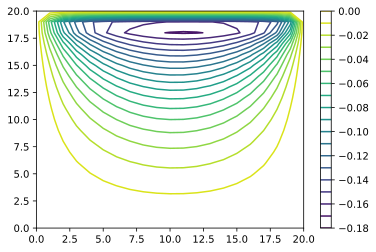

In [11]:
solution = psi[-1]
plt.contour(solution,levels=20)
plt.colorbar()

## Calculate the velocity vector field
The next step is to calculate the velocity vector field and double check that we are divergence free

In [ ]:
ψ = psi[-1]
u = np.zeros([ny,nx])
v = np.zeros([ny,nx])

u[1:-1,1:-1] = (ψ[2:,1:-1] - ψ[:-2,1:-1])/2.0/dy
v[1:-1,1:-1] = -(ψ[1:-1, 2:] - ψ[1:-1,:-2])/2.0/dx

# now will in the boundary values - they are all zero except at the top boundary where u = Ut
u[-1,1:-1] = Ut
divu = (u[1:-1,2:] - u[1:-1,:-2])/2.0/dx + (v[2:,1:-1] - v[:-2,1:-1])/2.0/dy
print(np.linalg.norm(divu.ravel()))

# note the size of the velocity vector field - it does not have points at the boundaries.

## Create some beautiful plots

In [ ]:
x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)
xx,yy = np.meshgrid(x,y)
nn = 1
plt.quiver(xx[::nn,::nn],yy[::nn,::nn],u[::nn,::nn],v[::nn,::nn])
# plt.quiver(xx[1:-1:nn,1:-1:nn],yy[1:-1:nn,1:-1:nn],u[::nn,::nn],v[::nn,::nn])
# plt.axis('equal')

In [ ]:
fig = plt.figure(figsize=[6,6],dpi=600)
ax = fig.add_subplot(111)
ax.contourf(xx, yy, np.sqrt(u*u + v*v), levels = 100, cmap=plt.cm.jet)
ax.streamplot(xx,yy,u, v, color=np.sqrt(u*u + v*v),density=1.1,cmap=plt.cm.autumn,linewidth=1.5)
# ax.set_xlim([xx[0,0],xx[0,-1]])
# ax.set_ylim([0,1])
# ax.set_aspect(1)

In [ ]:
x = np.linspace(0,1,nx)
y = np.linspace(0,1,ny)
xx,yy = np.meshgrid(x,y)
nn = 3

fig = plt.figure(figsize=(6.1,5),facecolor='w',dpi=150)
ax = fig.add_subplot(111)


ims = []
# levs = np.linspace(-1,1,20)
i = 0
t = 0.0
for sol in psi:    
    if (i%10==0):      
        u = (sol[2:,1:-1] - sol[:-2,1:-1])/2.0/dy
        v = -(sol[1:-1, 2:] - sol[1:-1,:-2])/2.0/dx
        im = ax.contourf(xx[1:-1,1:-1], yy[1:-1,1:-1], np.sqrt(u*u + v*v), levels = 100, cmap=plt.cm.jet)
#         im = ax.streamplot(xx[1:-1,1:-1],yy[1:-1,1:-1],u,v, color=abs(u*u + v*v),cmap=plt.cm.autumn,linewidth=1.0)
#         im = plt.contourf(solution,cmap=cm.jet,levels=100)
        ims.append(im.collections)
    i+=1
    t += dt

ax.set_xlim([0,1])
ax.set_ylim([0,1])
ax.set_aspect(1)

# cbar = plt.colorbar()
# plt.clim(-10,10)
# cbar.set_ticks(np.linspace(0,10,5))

ani = animation.ArtistAnimation(fig, ims, interval=35, blit=True,repeat_delay=1000)

ani

In [ ]:
divu = (u[1:-1, 2:] - u[1:-1,:-2])/2.0/dx + (v[2:,1:-1] - v[:-2,1:-1])/2.0/dy

In [ ]:
plt.imshow(divu)
plt.colorbar()

In [ ]:
import urllib
import requests
from IPython.core.display import HTML
def css_styling():
    styles = requests.get("https://raw.githubusercontent.com/saadtony/NumericalMethods/master/styles/custom.css")
    return HTML(styles.text)
css_styling()
